Import necessary dependencies

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
from datetime import datetime

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# elif torch.backends.mps.is_available():
#     device = torch.device("mps:0")
else:
    device = torch.device("cpu")

Load data

In [4]:
data = pd.read_csv('IoT_Modbus.csv')

# TODO: Complete EDA

Combine 'date' and 'time' into a single datetime column

In [5]:
data['date'] = data['date'].str.strip()
data['time'] = data['time'].str.strip()
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'], format='%d-%b-%y %H:%M:%S')

Extract time features

In [6]:
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['minute'] = data['datetime'].dt.minute
data['second'] = data['datetime'].dt.second
data['dayofweek'] = data['datetime'].dt.dayofweek

Time series models need to ensure that the data set is arranged in time order

In [7]:
# Sort the data by datetime
data = data.sort_values(by='datetime')

# Drop the original date, time, and timestamp columns
data.drop(['date', 'time', 'datetime', 'type'], axis=1, inplace=True)

# Adjust feature order
order = ['year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek', 'FC1_Read_Input_Register', 'FC2_Read_Discrete_Value', 'FC3_Read_Holding_Register', 'FC4_Read_Coil', 'label']
data = data[order].astype('int32')

# Split the dataset (Sequential Split)

In [8]:
# Calculate split points
split_idx = int(len(data) * 0.8)

# Split the data set, keeping order
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

# Separate features and labels
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

# Data preprocessing (Normalization)

In [9]:
feature_columns = [col for col in X_train.columns if col != 'label']
scaler = MinMaxScaler()

X_train[feature_columns] = scaler.fit_transform(X_train[feature_columns]).astype('float32')
X_test[feature_columns] = scaler.transform(X_test[feature_columns]).astype('float32')
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229755 entries, 541 to 184368
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   year                       229755 non-null  float32
 1   month                      229755 non-null  float32
 2   day                        229755 non-null  float32
 3   hour                       229755 non-null  float32
 4   minute                     229755 non-null  float32
 5   second                     229755 non-null  float32
 6   dayofweek                  229755 non-null  float32
 7   FC1_Read_Input_Register    229755 non-null  float32
 8   FC2_Read_Discrete_Value    229755 non-null  float32
 9   FC3_Read_Holding_Register  229755 non-null  float32
 10  FC4_Read_Coil              229755 non-null  float32
dtypes: float32(11)
memory usage: 11.4 MB


# Execution model
## Create model

In [11]:
class LightweightLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, width_multiplier=1.0):
        super(LightweightLSTM, self).__init__()
        # Adjust hidden size based on the width multiplier
        adjusted_hidden_size = int(hidden_size * width_multiplier)

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, adjusted_hidden_size, num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(adjusted_hidden_size, output_size)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)

        # Take the output of the last time step
        last_time_step_out = lstm_out[:, -1, :]

        # Output layer
        out = self.fc(last_time_step_out)
        return out

Initialize model

In [12]:
features_num = X_train.shape[1]
hidden_neurons_num = 512
output_neurons_num = 1
lstm_num_layers = 2
multiplier = 0.5

model = LightweightLSTM(features_num, hidden_neurons_num, output_neurons_num, lstm_num_layers, multiplier).to(device)

In [13]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device=device)

Build loss functions and optimizers

In [14]:
weights = torch.tensor([1, class_weights[1]], dtype=torch.float)
criterion = nn.BCEWithLogitsLoss(torch.FloatTensor ([weights[1] / weights[0]])).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Construct Data Loader

In [15]:
batch_size = 128

# Use to_numpy is much better than .values
X_train_tensor: torch.Tensor = torch.tensor(X_train.to_numpy()).float().unsqueeze(1).to(device)
X_test_tensor: torch.Tensor = torch.tensor(X_test.to_numpy()).float().unsqueeze(1).to(device)

y_train_tensor: torch.Tensor = torch.tensor(y_train.to_numpy()).float().unsqueeze(1).to(device)
y_test_tensor: torch.Tensor = torch.tensor(y_test.to_numpy()).float().unsqueeze(1).to(device)


train_dataset: torch.utils.data.dataset.TensorDataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader: torch.utils.data.dataloader.DataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset: torch.utils.data.dataset.TensorDataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader: torch.utils.data.dataloader.DataLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training model

In [16]:
num_epochs = 100
pbar = tqdm(total=num_epochs)
loss_list = [None] * num_epochs
acc_list = [None] * num_epochs
loss_list_train = [None] * num_epochs


for epoch in range(num_epochs):
    model.train()
    loss_storage = 0
    for inputs, labels in train_loader:
        # FP
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_storage += loss.item() * inputs.size(0)

        # BP and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate indicators
    model.eval()

    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)

            probabilities = torch.sigmoid(outputs)

            loss = criterion(probabilities, labels)

            # Calculate indicators
            running_loss += loss.item() * inputs.size(0)

            predictions = (probabilities > 0.5).float().to(device)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_train_loss = loss_storage / len(train_loader.dataset)
    epoch_val_loss = running_loss / len(test_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)

    loss_list[epoch] = epoch_val_loss
    acc_list[epoch] = accuracy

    pbar.update(1)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss_train: {epoch_train_loss}, Loss_test: {epoch_val_loss}, Accuracy_test: {accuracy}')

pbar.close()

  1%|          | 1/100 [00:09<16:26,  9.96s/it]

Epoch [1/100], Loss_train: 0.5964104877642235, Loss_test: 2.1697040248102715, Accuracy_test: 0.1377461306777625


  2%|▏         | 2/100 [00:17<14:21,  8.79s/it]

Epoch [2/100], Loss_train: 0.669694794785923, Loss_test: 2.339957746195655, Accuracy_test: 0.1377461306777625


  3%|▎         | 3/100 [00:25<13:33,  8.39s/it]

Epoch [3/100], Loss_train: 0.6843494546400191, Loss_test: 2.3165897401412443, Accuracy_test: 0.1377461306777625


  4%|▍         | 4/100 [00:33<13:07,  8.20s/it]

Epoch [4/100], Loss_train: 0.6336451421378039, Loss_test: 2.369282616295334, Accuracy_test: 0.1377461306777625


  5%|▌         | 5/100 [00:41<12:51,  8.12s/it]

Epoch [5/100], Loss_train: 0.6039776350769983, Loss_test: 2.367040196501795, Accuracy_test: 0.1377461306777625


  6%|▌         | 6/100 [00:49<12:40,  8.09s/it]

Epoch [6/100], Loss_train: 0.5598199455469101, Loss_test: 2.3693834102390996, Accuracy_test: 0.1377461306777625


  7%|▋         | 7/100 [00:57<12:31,  8.08s/it]

Epoch [7/100], Loss_train: 0.5136654465436242, Loss_test: 2.369381224595022, Accuracy_test: 0.1377461306777625


  8%|▊         | 8/100 [01:05<12:20,  8.05s/it]

Epoch [8/100], Loss_train: 0.5095035444775091, Loss_test: 2.3593507600168087, Accuracy_test: 0.1377461306777625


  9%|▉         | 9/100 [01:13<12:10,  8.03s/it]

Epoch [9/100], Loss_train: 0.59587621144899, Loss_test: 2.3276361720172924, Accuracy_test: 0.1377461306777625


 10%|█         | 10/100 [01:21<12:01,  8.01s/it]

Epoch [10/100], Loss_train: 0.6586114854629538, Loss_test: 2.3632553118484245, Accuracy_test: 0.1377461306777625


 11%|█         | 11/100 [01:29<11:52,  8.00s/it]

Epoch [11/100], Loss_train: 0.5008636190030306, Loss_test: 2.3505997557243177, Accuracy_test: 0.1377461306777625


 12%|█▏        | 12/100 [01:37<11:46,  8.03s/it]

Epoch [12/100], Loss_train: 0.5035564825108699, Loss_test: 2.334021824370329, Accuracy_test: 0.1377461306777625


 13%|█▎        | 13/100 [01:45<11:40,  8.05s/it]

Epoch [13/100], Loss_train: 0.5051079417201957, Loss_test: 2.3263121478045665, Accuracy_test: 0.1377461306777625


 14%|█▍        | 14/100 [01:54<11:32,  8.05s/it]

Epoch [14/100], Loss_train: 0.5675004213949155, Loss_test: 2.186964103522603, Accuracy_test: 0.1377461306777625


 15%|█▌        | 15/100 [02:02<11:27,  8.09s/it]

Epoch [15/100], Loss_train: 0.5015328603913788, Loss_test: 2.342761987111419, Accuracy_test: 0.1377461306777625


 16%|█▌        | 16/100 [02:10<11:26,  8.17s/it]

Epoch [16/100], Loss_train: 0.47512413377951973, Loss_test: 2.308000452627754, Accuracy_test: 0.1377461306777625


 17%|█▋        | 17/100 [02:18<11:16,  8.15s/it]

Epoch [17/100], Loss_train: 0.4395224912374176, Loss_test: 2.331303339245762, Accuracy_test: 0.1377461306777625


 18%|█▊        | 18/100 [02:26<11:07,  8.13s/it]

Epoch [18/100], Loss_train: 0.45995689080382174, Loss_test: 2.3339310800317965, Accuracy_test: 0.1377461306777625


 19%|█▉        | 19/100 [02:35<11:21,  8.42s/it]

Epoch [19/100], Loss_train: 0.4192421185232496, Loss_test: 2.321125616243028, Accuracy_test: 0.1377461306777625


 20%|██        | 20/100 [02:43<11:07,  8.34s/it]

Epoch [20/100], Loss_train: 0.41206402237285705, Loss_test: 2.3137133596800137, Accuracy_test: 0.1377461306777625


 21%|██        | 21/100 [02:53<11:19,  8.60s/it]

Epoch [21/100], Loss_train: 0.41166289465354394, Loss_test: 2.307564516548501, Accuracy_test: 0.1377461306777625


 22%|██▏       | 22/100 [03:03<11:40,  8.98s/it]

Epoch [22/100], Loss_train: 0.41529551067888476, Loss_test: 2.301784680255324, Accuracy_test: 0.1377461306777625


 23%|██▎       | 23/100 [03:11<11:29,  8.95s/it]

Epoch [23/100], Loss_train: 0.414420641396211, Loss_test: 2.3015822873133556, Accuracy_test: 0.1377461306777625


 24%|██▍       | 24/100 [03:20<11:01,  8.71s/it]

Epoch [24/100], Loss_train: 0.41173802682149474, Loss_test: 2.293537057735526, Accuracy_test: 0.1377461306777625


 25%|██▌       | 25/100 [03:28<10:41,  8.55s/it]

Epoch [25/100], Loss_train: 0.41266504468999515, Loss_test: 2.2837747049214614, Accuracy_test: 0.1377461306777625


 26%|██▌       | 26/100 [03:36<10:23,  8.42s/it]

Epoch [26/100], Loss_train: 0.4104208227780041, Loss_test: 2.274366164992377, Accuracy_test: 0.1377461306777625


 27%|██▋       | 27/100 [03:44<10:09,  8.36s/it]

Epoch [27/100], Loss_train: 0.41285642304980974, Loss_test: 2.2641341366179546, Accuracy_test: 0.1377461306777625


 28%|██▊       | 28/100 [03:52<10:02,  8.37s/it]

Epoch [28/100], Loss_train: 0.4096586288529394, Loss_test: 2.2518348377929236, Accuracy_test: 0.1377461306777625


 29%|██▉       | 29/100 [04:01<09:52,  8.34s/it]

Epoch [29/100], Loss_train: 0.4018406647318533, Loss_test: 2.2372325477718977, Accuracy_test: 0.1377461306777625


 30%|███       | 30/100 [04:09<09:46,  8.38s/it]

Epoch [30/100], Loss_train: 0.39308303011943, Loss_test: 2.220451780725263, Accuracy_test: 0.1377461306777625


 31%|███       | 31/100 [04:17<09:35,  8.34s/it]

Epoch [31/100], Loss_train: 0.38578720063061345, Loss_test: 2.203819194127512, Accuracy_test: 0.1377461306777625


 32%|███▏      | 32/100 [04:26<09:25,  8.31s/it]

Epoch [32/100], Loss_train: 0.3791563038454904, Loss_test: 2.1950010294311464, Accuracy_test: 0.1377461306777625


 33%|███▎      | 33/100 [04:34<09:26,  8.45s/it]

Epoch [33/100], Loss_train: 0.37366580407275585, Loss_test: 2.1819966206068853, Accuracy_test: 0.1377461306777625


 34%|███▍      | 34/100 [04:43<09:22,  8.52s/it]

Epoch [34/100], Loss_train: 0.36936701103225067, Loss_test: 2.166997876762773, Accuracy_test: 0.1377461306777625


 35%|███▌      | 35/100 [04:52<09:11,  8.48s/it]

Epoch [35/100], Loss_train: 0.3660394508134548, Loss_test: 2.1477654696893085, Accuracy_test: 0.1377461306777625


 36%|███▌      | 36/100 [05:00<09:00,  8.44s/it]

Epoch [36/100], Loss_train: 0.36338695175787317, Loss_test: 2.1274664944436372, Accuracy_test: 0.1377461306777625


 37%|███▋      | 37/100 [05:08<08:50,  8.42s/it]

Epoch [37/100], Loss_train: 0.36134334323400574, Loss_test: 2.1088903964081567, Accuracy_test: 0.1377461306777625


 38%|███▊      | 38/100 [05:17<08:41,  8.42s/it]

Epoch [38/100], Loss_train: 0.35889308150168714, Loss_test: 2.0907180049496237, Accuracy_test: 0.1377461306777625


 39%|███▉      | 39/100 [05:25<08:31,  8.39s/it]

Epoch [39/100], Loss_train: 0.35677594667200074, Loss_test: 2.0756542366521744, Accuracy_test: 0.13811173592855028


 40%|████      | 40/100 [05:33<08:20,  8.35s/it]

Epoch [40/100], Loss_train: 0.35812213912829577, Loss_test: 2.0654907218385397, Accuracy_test: 0.14161110047180486


 41%|████      | 41/100 [05:41<08:10,  8.32s/it]

Epoch [41/100], Loss_train: 0.3549803605830697, Loss_test: 2.0583629685297167, Accuracy_test: 0.1437525026549905


 42%|████▏     | 42/100 [05:50<08:05,  8.36s/it]

Epoch [42/100], Loss_train: 0.35346286279922534, Loss_test: 2.0382974569311747, Accuracy_test: 0.19274360626055467


 43%|████▎     | 43/100 [05:58<07:58,  8.40s/it]

Epoch [43/100], Loss_train: 0.35324482289617615, Loss_test: 2.020685786201744, Accuracy_test: 0.24210031511690663


 44%|████▍     | 44/100 [06:07<07:50,  8.40s/it]

Epoch [44/100], Loss_train: 0.3520802696019501, Loss_test: 2.0043266426730564, Accuracy_test: 0.280558505545013


 45%|████▌     | 45/100 [06:15<07:45,  8.47s/it]

Epoch [45/100], Loss_train: 0.35306165781948173, Loss_test: 1.9884933235544056, Accuracy_test: 0.3166141471822281


 46%|████▌     | 46/100 [06:24<07:42,  8.57s/it]

Epoch [46/100], Loss_train: 0.35247871504181755, Loss_test: 1.971521655306863, Accuracy_test: 0.3501976009331639


 47%|████▋     | 47/100 [06:34<07:46,  8.79s/it]

Epoch [47/100], Loss_train: 0.35517417691605147, Loss_test: 1.9562127432490037, Accuracy_test: 0.3798290360208221


 48%|████▊     | 48/100 [06:43<07:47,  8.99s/it]

Epoch [48/100], Loss_train: 0.35486653031439835, Loss_test: 1.9396826211936993, Accuracy_test: 0.40977384703772696


 49%|████▉     | 49/100 [06:53<07:47,  9.17s/it]

Epoch [49/100], Loss_train: 0.3572312042996248, Loss_test: 1.9219699355789241, Accuracy_test: 0.4381169588607044


 50%|█████     | 50/100 [07:03<07:53,  9.47s/it]

Epoch [50/100], Loss_train: 0.3598752648054869, Loss_test: 1.9038849779568283, Accuracy_test: 0.46602482633750586


 51%|█████     | 51/100 [07:12<07:46,  9.53s/it]

Epoch [51/100], Loss_train: 0.3628980953507517, Loss_test: 1.884931787240119, Accuracy_test: 0.49166942321419244


 52%|█████▏    | 52/100 [07:22<07:37,  9.52s/it]

Epoch [52/100], Loss_train: 0.36594963144312387, Loss_test: 1.865745677983944, Accuracy_test: 0.5169310050662442


 53%|█████▎    | 53/100 [07:31<07:13,  9.22s/it]

Epoch [53/100], Loss_train: 0.37221647708207606, Loss_test: 1.8495261558041658, Accuracy_test: 0.5379271923257717


 54%|█████▍    | 54/100 [07:39<06:55,  9.02s/it]

Epoch [54/100], Loss_train: 0.3722908874214634, Loss_test: 1.8298309762658975, Accuracy_test: 0.563467330559376


 55%|█████▌    | 55/100 [07:47<06:38,  8.85s/it]

Epoch [55/100], Loss_train: 0.3774447675376447, Loss_test: 1.813106956381733, Accuracy_test: 0.583279653197305


 56%|█████▌    | 56/100 [07:56<06:25,  8.75s/it]

Epoch [56/100], Loss_train: 0.3815801008211525, Loss_test: 1.7976853484805575, Accuracy_test: 0.6022911262382702


 57%|█████▋    | 57/100 [08:04<06:12,  8.66s/it]

Epoch [57/100], Loss_train: 0.38508828679062235, Loss_test: 1.7835123443336203, Accuracy_test: 0.6235310503316562


 58%|█████▊    | 58/100 [08:13<06:03,  8.64s/it]

Epoch [58/100], Loss_train: 0.38716136277767293, Loss_test: 1.7862643730976835, Accuracy_test: 0.6157140618743363


 59%|█████▉    | 59/100 [08:22<05:52,  8.59s/it]

Epoch [59/100], Loss_train: 0.3947917830417772, Loss_test: 1.7626678474903414, Accuracy_test: 0.6494193840422013


 60%|██████    | 60/100 [08:30<05:42,  8.56s/it]

Epoch [60/100], Loss_train: 0.39888312469295595, Loss_test: 1.7420814897018746, Accuracy_test: 0.6902104841658107


 61%|██████    | 61/100 [08:38<05:32,  8.53s/it]

Epoch [61/100], Loss_train: 0.39836904155654995, Loss_test: 1.729673708391529, Accuracy_test: 0.7129302390361949


 62%|██████▏   | 62/100 [08:47<05:23,  8.52s/it]

Epoch [62/100], Loss_train: 0.3966319455950126, Loss_test: 1.7160506853289161, Accuracy_test: 0.7276589077107888


 63%|██████▎   | 63/100 [08:55<05:14,  8.50s/it]

Epoch [63/100], Loss_train: 0.3937392603469966, Loss_test: 1.739338235608212, Accuracy_test: 0.6529187485854558


 64%|██████▍   | 64/100 [09:04<05:06,  8.52s/it]

Epoch [64/100], Loss_train: 0.39748643464770556, Loss_test: 1.6702332243754752, Accuracy_test: 0.7532164557182403


 65%|██████▌   | 65/100 [09:13<04:59,  8.56s/it]

Epoch [65/100], Loss_train: 0.40561974867854783, Loss_test: 1.6215141237121402, Accuracy_test: 0.8498058810216055


 66%|██████▌   | 66/100 [09:21<04:50,  8.56s/it]

Epoch [66/100], Loss_train: 0.43293460346689383, Loss_test: 1.6285719308566908, Accuracy_test: 0.8543324222218354


 67%|██████▋   | 67/100 [09:30<04:42,  8.56s/it]

Epoch [67/100], Loss_train: 0.4142447830432596, Loss_test: 1.6616892160094443, Accuracy_test: 0.8174062918922683


 68%|██████▊   | 68/100 [09:38<04:33,  8.55s/it]

Epoch [68/100], Loss_train: 0.3947426517545299, Loss_test: 1.6470906054916115, Accuracy_test: 0.838054283674855


 69%|██████▉   | 69/100 [09:47<04:25,  8.57s/it]

Epoch [69/100], Loss_train: 0.38847097999231645, Loss_test: 1.6237499072347963, Accuracy_test: 0.85971204234057


 70%|███████   | 70/100 [09:55<04:16,  8.56s/it]

Epoch [70/100], Loss_train: 0.3849506197701324, Loss_test: 1.6016034433861173, Accuracy_test: 0.8814394401016731


 71%|███████   | 71/100 [10:04<04:07,  8.53s/it]

Epoch [71/100], Loss_train: 0.3843858293869131, Loss_test: 1.5863763386829768, Accuracy_test: 0.8907710788836853


 72%|███████▏  | 72/100 [10:13<04:03,  8.69s/it]

Epoch [72/100], Loss_train: 0.38213004623044283, Loss_test: 1.5692102527545353, Accuracy_test: 0.9055345671059732


 73%|███████▎  | 73/100 [10:22<03:54,  8.68s/it]

Epoch [73/100], Loss_train: 0.3785413571769779, Loss_test: 1.5447243877406007, Accuracy_test: 0.91601525096189


 74%|███████▍  | 74/100 [10:30<03:45,  8.67s/it]

Epoch [74/100], Loss_train: 0.3746191526382746, Loss_test: 1.5229768087448052, Accuracy_test: 0.9197931718866972


 75%|███████▌  | 75/100 [10:39<03:35,  8.63s/it]

Epoch [75/100], Loss_train: 0.3700502047612882, Loss_test: 1.510722971250591, Accuracy_test: 0.9202632357805672


 76%|███████▌  | 76/100 [10:47<03:26,  8.59s/it]

Epoch [76/100], Loss_train: 0.3644276866105341, Loss_test: 1.5145326929401726, Accuracy_test: 0.9158237434495726


 77%|███████▋  | 77/100 [10:56<03:17,  8.60s/it]

Epoch [77/100], Loss_train: 0.35676317255047946, Loss_test: 1.518335955615213, Accuracy_test: 0.9101829767231324


 78%|███████▊  | 78/100 [11:05<03:09,  8.60s/it]

Epoch [78/100], Loss_train: 0.353700319460371, Loss_test: 1.5108027121144858, Accuracy_test: 0.9085638677553579


 79%|███████▉  | 79/100 [11:13<03:01,  8.64s/it]

Epoch [79/100], Loss_train: 0.3630291388158803, Loss_test: 1.4705058344165234, Accuracy_test: 0.9212207733421542


 80%|████████  | 80/100 [11:22<02:52,  8.65s/it]

Epoch [80/100], Loss_train: 0.3573609307577837, Loss_test: 1.4575364461742335, Accuracy_test: 0.9260781002454778


 81%|████████  | 81/100 [11:31<02:43,  8.62s/it]

Epoch [81/100], Loss_train: 0.35104533666876214, Loss_test: 1.4710205616078738, Accuracy_test: 0.9212730026636954


 82%|████████▏ | 82/100 [11:39<02:34,  8.60s/it]

Epoch [82/100], Loss_train: 0.3401361015343548, Loss_test: 1.4686220044696556, Accuracy_test: 0.918800814777416


 83%|████████▎ | 83/100 [11:48<02:25,  8.59s/it]

Epoch [83/100], Loss_train: 0.3430922435981686, Loss_test: 1.4486219308181183, Accuracy_test: 0.931283622625742


 84%|████████▍ | 84/100 [11:56<02:18,  8.65s/it]

Epoch [84/100], Loss_train: 0.3405119274486264, Loss_test: 1.4419268404292467, Accuracy_test: 0.9352704608367137


 85%|████████▌ | 85/100 [12:06<02:14,  8.96s/it]

Epoch [85/100], Loss_train: 0.33109732300815353, Loss_test: 1.4491826402258767, Accuracy_test: 0.9356012465398075


 86%|████████▌ | 86/100 [12:15<02:04,  8.91s/it]

Epoch [86/100], Loss_train: 0.3207198588443273, Loss_test: 1.4665538029853433, Accuracy_test: 0.923396995073034


 87%|████████▋ | 87/100 [12:24<01:56,  8.94s/it]

Epoch [87/100], Loss_train: 0.31924137900020516, Loss_test: 1.6510500426590364, Accuracy_test: 0.7958007625480945


 88%|████████▊ | 88/100 [12:33<01:47,  8.98s/it]

Epoch [88/100], Loss_train: 0.3231779370628676, Loss_test: 1.5048497319335643, Accuracy_test: 0.923849649193057


 89%|████████▉ | 89/100 [12:42<01:39,  9.06s/it]

Epoch [89/100], Loss_train: 0.2973893920333633, Loss_test: 1.4799812550033276, Accuracy_test: 0.9283413708455928


 90%|█████████ | 90/100 [12:52<01:31,  9.20s/it]

Epoch [90/100], Loss_train: 0.2839182975909049, Loss_test: 1.5996604729944806, Accuracy_test: 0.8859659813019028


 91%|█████████ | 91/100 [13:00<01:21,  9.01s/it]

Epoch [91/100], Loss_train: 0.25515764702211247, Loss_test: 1.59531433679767, Accuracy_test: 0.9042462438412925


 92%|█████████▏| 92/100 [13:09<01:11,  8.91s/it]

Epoch [92/100], Loss_train: 0.2534920053045057, Loss_test: 1.5225118605439159, Accuracy_test: 0.9179999651804523


 93%|█████████▎| 93/100 [13:18<01:01,  8.84s/it]

Epoch [93/100], Loss_train: 0.24946961616392205, Loss_test: 1.5083047817833388, Accuracy_test: 0.9098347812461917


 94%|█████████▍| 94/100 [13:26<00:52,  8.77s/it]

Epoch [94/100], Loss_train: 0.2417677225263357, Loss_test: 1.504249875202935, Accuracy_test: 0.8912411427775553


 95%|█████████▌| 95/100 [13:35<00:44,  8.82s/it]

Epoch [95/100], Loss_train: 0.23645405383680348, Loss_test: 1.4857029489646618, Accuracy_test: 0.8908407179790735


 96%|█████████▌| 96/100 [13:44<00:35,  8.79s/it]

Epoch [96/100], Loss_train: 0.2327638269241201, Loss_test: 1.4779078479007346, Accuracy_test: 0.8835286129633176


 97%|█████████▋| 97/100 [13:53<00:26,  8.85s/it]

Epoch [97/100], Loss_train: 0.22805068710727644, Loss_test: 1.4812419867789102, Accuracy_test: 0.8520169223001793


 98%|█████████▊| 98/100 [14:02<00:17,  8.89s/it]

Epoch [98/100], Loss_train: 0.22433695223955594, Loss_test: 1.4862572430804732, Accuracy_test: 0.8368355995055624


 99%|█████████▉| 99/100 [14:11<00:09,  9.05s/it]

Epoch [99/100], Loss_train: 0.22431960195337247, Loss_test: 1.4837830305767767, Accuracy_test: 0.8249273141941886


100%|██████████| 100/100 [14:20<00:00,  8.61s/it]

Epoch [100/100], Loss_train: 0.22239398869192623, Loss_test: 1.4910042290443577, Accuracy_test: 0.8190602204077368


Visualizing the training process

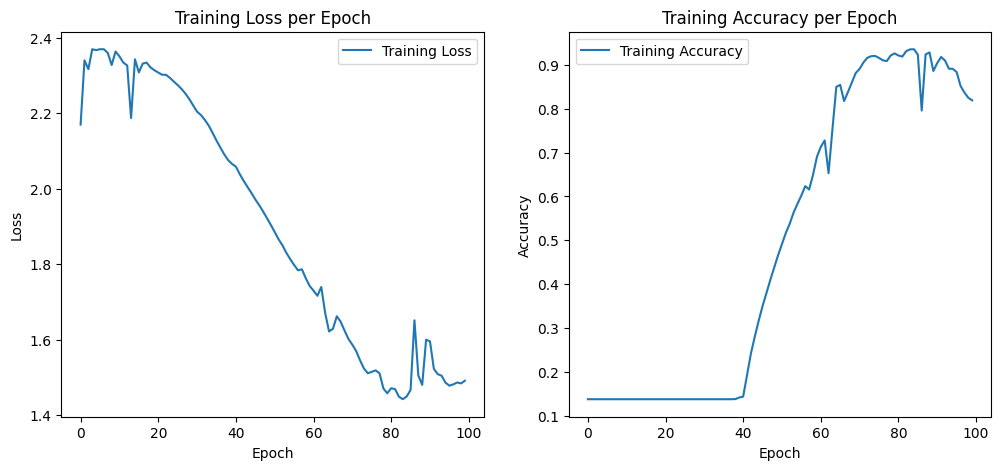

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Draw accuracy curve
plt.subplot(1, 2, 2)
plt.plot(acc_list, label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Unseen test set performance

In [18]:
X_test_tensor = torch.tensor(X_test.values).float().unsqueeze(1).to(device)

model.eval()
outputs = model(X_test_tensor)
with torch.no_grad():
    probabilities = torch.sigmoid(outputs)
    predictions = (probabilities > 0.5).float().cpu().numpy()

    # Calculate indicators
    acc = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    print("Accuracy: ", acc, ", Precision: ", precision, ", Recall: ", recall, ", F1: ", f1)

Accuracy:  0.8190602204077368 , Precision:  0.4252034971359662 , Recall:  0.8913043478260869 , F1:  0.5757439686492224


Save model

In [19]:
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_filename = f"model_{current_time}.pt"
torch.save(model.state_dict(), model_filename)

print("Model saved as:", model_filename)

Model saved as: model_2023-11-20_16-01-21.pt
